# Question

There is a formal list of medical surgery names, defined in surgeries.txt.
Then in doctors’ notes, there is a field called "surgery names". doctor_written_surgery_name.txt is a sample of it. We want a method to check if each doctor written surgery name could be matched to a formal surgery name or not. A few things to notice:

1) in doctors’ notes, there could be typos.

2) some words are short, but they are important, for example “hip replacement” and “wrist replacement” are totaly different things, although they have a long common substring.

3) some substrings, like ‘ectomy’, ‘replacement’ might appear in many different surgeries names.

4) different word orders might not matter, for example "hip arthroplasty total" and "total hip arthroplasty" mean the same thing.

5) There is no labeled training data.

# Solution

### Author: Linsu Han

## 1) Basic Cleaning

In [1]:
import pandas as pd
import string

In [2]:
with open('../data/doctor-notes/surgeries.txt', 'r') as f:
    names = f.readlines()
    
with open('../data/doctor-notes/doctor_written_surgery_name.txt', 'r') as f:
    notes = f.readlines()

In [3]:
def clean_text(text): 
    delete_dict = {sp_character:'' for sp_character in string.punctuation} # filter punct
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    textlist = text1.split()
    text2 = ' '.join([w for w in textlist if not w.isdigit()]) # delete digits
    return text2.lower()

In [4]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [5]:
notes_clean = [clean_text(note) for note in notes]
names_clean = [clean_text(name) for name in names]

In [6]:
notes_clean[:5]

['scheduled',
 'l shoulder arthroscopy',
 'will be on',
 'schedule frobotic assisted laparoscopic assisted versus open',
 'diastasis recti']

In [7]:
names_clean[:5]

['abdominoplasty',
 'panniculectomy',
 'achilles tendon',
 'peroneal tendon repair',
 'acl reconstruction']

## 2) Additional Preprocessing

### 2.1) Fixing Typos

In [8]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
# https://github.com/seatgeek/fuzzywuzzy

c:\program files\python38\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [9]:
spellings = set()
for phrase in names_clean:
    for word in phrase.split(' '):
        spellings.add(word)

In [10]:
typos = dict()
for note in notes_clean:
    for word in note.split(' '):
        closest_match, threshold = process.extractOne(word, spellings)
        if 90 < threshold < 100:
            typos[word] = closest_match
            print(word, closest_match, threshold)

cholecyctectomy cholecystectomy 93


arthoplasty arthroplasty 96
fusion fusions 92
bunionectoy bunionectomy 96
catheterization catherization 93
replacment replacement 95
cholocystectomy cholecystectomy 93
cathetarization catherization 93


fusion fusions 92
orthroplasty arthroplasty 92
arthoplasty arthroplasty 96


cholecustectomy cholecystectomy 93
injection injections 95


injection injections 95
anthroplasty arthroplasty 92
loparoscopy laparoscopy 91
fusion fusions 92
fusion fusions 92


appenoectomy appendectomy 92
fusion fusions 92
catherisation catherization 92
beast breast 91
appendectory appendectomy 92


released release 93


In [11]:
typos

{'cholecyctectomy': 'cholecystectomy',
 'arthoplasty': 'arthroplasty',
 'fusion': 'fusions',
 'bunionectoy': 'bunionectomy',
 'catheterization': 'catherization',
 'replacment': 'replacement',
 'cholocystectomy': 'cholecystectomy',
 'cathetarization': 'catherization',
 'orthroplasty': 'arthroplasty',
 'cholecustectomy': 'cholecystectomy',
 'injection': 'injections',
 'anthroplasty': 'arthroplasty',
 'loparoscopy': 'laparoscopy',
 'appenoectomy': 'appendectomy',
 'catherisation': 'catherization',
 'beast': 'breast',
 'appendectory': 'appendectomy',
 'released': 'release'}

In [12]:
def fix_typos(text): 
    for typo, correction in typos.items():
        text = text.replace(typo, correction)
    return text

In [13]:
fix_typos('total knee replacment manipulation under anesthesia')

'total knee replacement manipulation under anesthesia'

In [14]:
notes_clean_fixedtypos = [fix_typos(note) for note in notes_clean]

### 2.2) More

In [15]:
# for slighty more matches try lemmatizing / stemming

In [16]:
# bc the dataset is small, we could manually remove UNCOMMON useless terms (since idf only puts less weight on common terms)

In [17]:
# bc dataset is small, can manually permute different word orders that have similar meanings ("hip arthroplasty total" and "total hip arthroplasty") to better support the n-gram model

## 3) Use TF-IDF embeddings

In [18]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline

In [19]:
# Getting the max n-grams
max_phrase_len = 1
for name in names_clean:
    name_len = len(name.split(' '))
    if  name_len > max_phrase_len:
        max_phrase_len = name_len

In [20]:
tfv = TfidfVectorizer(min_df=3,
                      max_features=None,
                      strip_accents='unicode',
                      analyzer='word',
                      token_pattern=r'\w{1,}',
                      ngram_range=(1, max_phrase_len),
                      use_idf=True,
                      smooth_idf=True,
                      sublinear_tf=True,
                      stop_words='english')

In [21]:
tfv.fit(notes_clean_fixedtypos + names_clean)

TfidfVectorizer(min_df=3, ngram_range=(1, 4), stop_words='english',
                strip_accents='unicode', sublinear_tf=True,
                token_pattern='\\w{1,}')

In [22]:
notes_tfv = tfv.transform(notes_clean_fixedtypos) 
names_tfv = tfv.transform(names_clean)

In [23]:
print(notes_tfv.shape)
print(names_tfv.shape)

(306, 146)
(63, 146)


## 4) Get Similarities

In [24]:
similarities = []
for note in tqdm(notes_tfv, total=notes_tfv.shape[0]):
    cs_ = []
    for name in names_tfv:
        cs = cosine_similarity(note, name)[0][0]
        cs_.append(cs)
    argmax_cs = np.argmax(cs_)
    similarities.append((argmax_cs, cs_[argmax_cs]))

100%|████████████████████████████████████████████████████████████████████████████████| 306/306 [00:07<00:00, 40.45it/s]


In [25]:
print(similarities[:15])

[(0, 0.0), (0, 0.0), (0, 0.0), (45, 0.44504101549158), (0, 0.0), (0, 0.0), (0, 0.0), (0, 0.0), (26, 0.6597824379328586), (0, 0.0), (8, 0.5814988633349439), (40, 0.48872277819605203), (36, 0.6717174820214451), (0, 0.0), (0, 0.0)]


In [26]:
# Plot Similarity Percentiles
cs__ = [cs for arg_cs, cs in similarities]
percentiles = []
for i in range(100):
    percentiles.append(np.percentile(cs__, i))

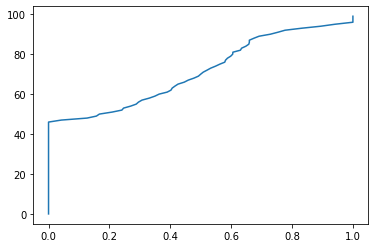

In [27]:
plt.plot(percentiles, np.arange(100))
plt.show()

In [28]:
print(percentiles[50]) # Median

0.16700450209690598


## 5) Results

In [29]:
n_matches = 0
threshold = percentiles[75] # use 75 percentile as cs threshold
i = 0
matches = []
for arg_cs, cs in similarities:
    if cs > threshold:
        matches.append((cs, notes[i][2:-3], notes_clean_fixedtypos[i], names_clean[arg_cs]))
        n_matches += 1
    i += 1

In [30]:
n_matches

77

In [31]:
matches.sort(key=lambda x: x[0], reverse=True)

In [32]:
df = pd.DataFrame(matches, columns=['Score', 'Doctors Notes', 'Doctors Notes (cleaned)', 'Formal Name (cleaned)'])

In [33]:
print(df.to_string())

       Score                                                                                                  Doctors Notes                                                                                        Doctors Notes (cleaned)                   Formal Name (cleaned)
0   1.000000                                                                        CARDIAC CATHETERIZATION 1/5/21, 1/21,21                                                                                          cardiac catherization                   cardiac catherization
1   1.000000                                                                                          CARDIAC CATHERISATION                                                                                          cardiac catherization                   cardiac catherization
2   1.000000                                                                                    LAPROSCOPIC CHOLECYSTECTOMY                                                    

## 6) Visualization

In [34]:
# Can use t-sne or PCA